## Import the needed libraries

In [2]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

# Visualization
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import seaborn as sns

#Neuronal networks
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.models import load_model
import keras
import utils

Using TensorFlow backend.


## Convert MP3 to WAV

All tracks should be change to wav format in order to work easily whit python

In [ ]:
path = '.\\data\\fma_small'
#utils.all_mp3_to_wav(path)

## Read metadata

In [6]:
AUDIO_DIR='.\\data\\fma_small'
META_DIR='.\\data\\fma_metadata'

features = utils.load(META_DIR+'\\features.csv')
echonest = utils.load(META_DIR+'\\echonest.csv')
genres = utils.load(META_DIR+'\\genres.csv')
tracks = utils.load(META_DIR+'\\tracks.csv')
#raw_tracks = utils.load(META_DIR+'\\raw_tracks.csv')
artists = utils.load(META_DIR+'\\raw_artists.csv')



C:\Users\User_01\Documents\Master\DeepLearning\Proyecto\fma\utils.py:232: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  'category', categories=SUBSETS, ordered=True)


## Get small subset of data

In [7]:
# Creating the subset 
small = tracks[tracks['set', 'subset'] <= 'small']

## Explore features of tracks using an arbitrary example

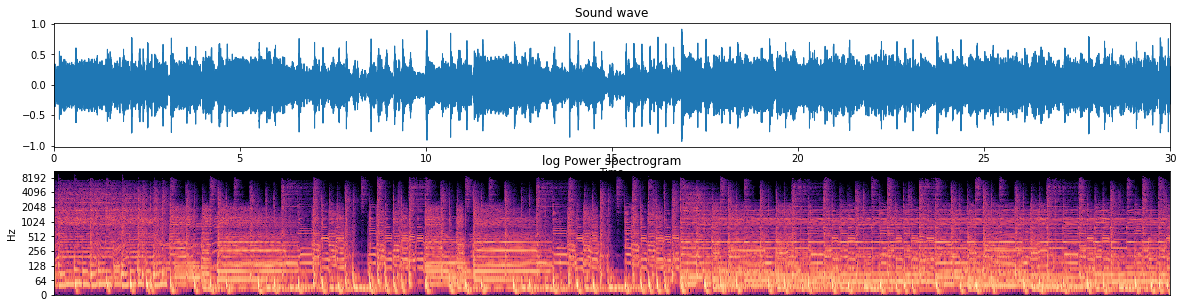

In [115]:
# Getting an arbitrary example
tid_example = 122077
filepath = utils.get_audio_path(AUDIO_DIR,tid_example)
example, sr = librosa.load(filepath, sr=None, mono=True)
example_S, phase = librosa.magphase(librosa.stft(example)) 

#Plotting representation of the track
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.title('Sound wave')
librosa.display.waveplot(example, sr=sr)
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(example_S, ref=np.max), y_axis='log')
plt.title('log Power spectrogram')
plt.show()

ipd.Audio(filepath) 

### Constant-Q chromagram, Chroma Energy Normalized y stft Chornogram
#### Explanation:
https://en.wikipedia.org/wiki/Constant-Q_transform 
https://labrosa.ee.columbia.edu/matlab/chroma-ansyn/

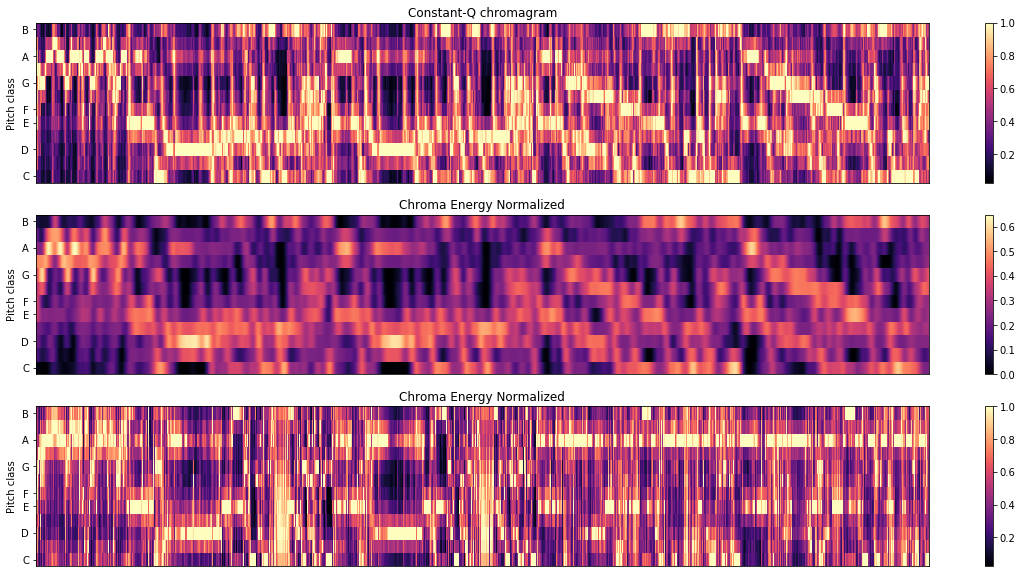

In [109]:
chroma_cq   = librosa.feature.chroma_cqt(y=example, sr=sr)
chroma_cens = librosa.feature.chroma_cens(y=example, sr=sr)
chroma_stft = librosa.feature.chroma_stft(y=example, sr=sr)

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
librosa.display.specshow(chroma_cq, y_axis='chroma')
plt.title('Constant-Q chromagram')
plt.colorbar()
plt.subplot(3,1,2)
librosa.display.specshow(chroma_cens, y_axis='chroma')
plt.title('Chroma Energy Normalized')
plt.colorbar()
plt.subplot(3,1,3)
librosa.display.specshow(chroma_stft, y_axis='chroma')
plt.title('Chroma Energy Normalized')
plt.colorbar()
plt.show()

### Root Mean Square (RMS) energy 
#### Explanation:
https://en.wikipedia.org/wiki/Root_mean_square

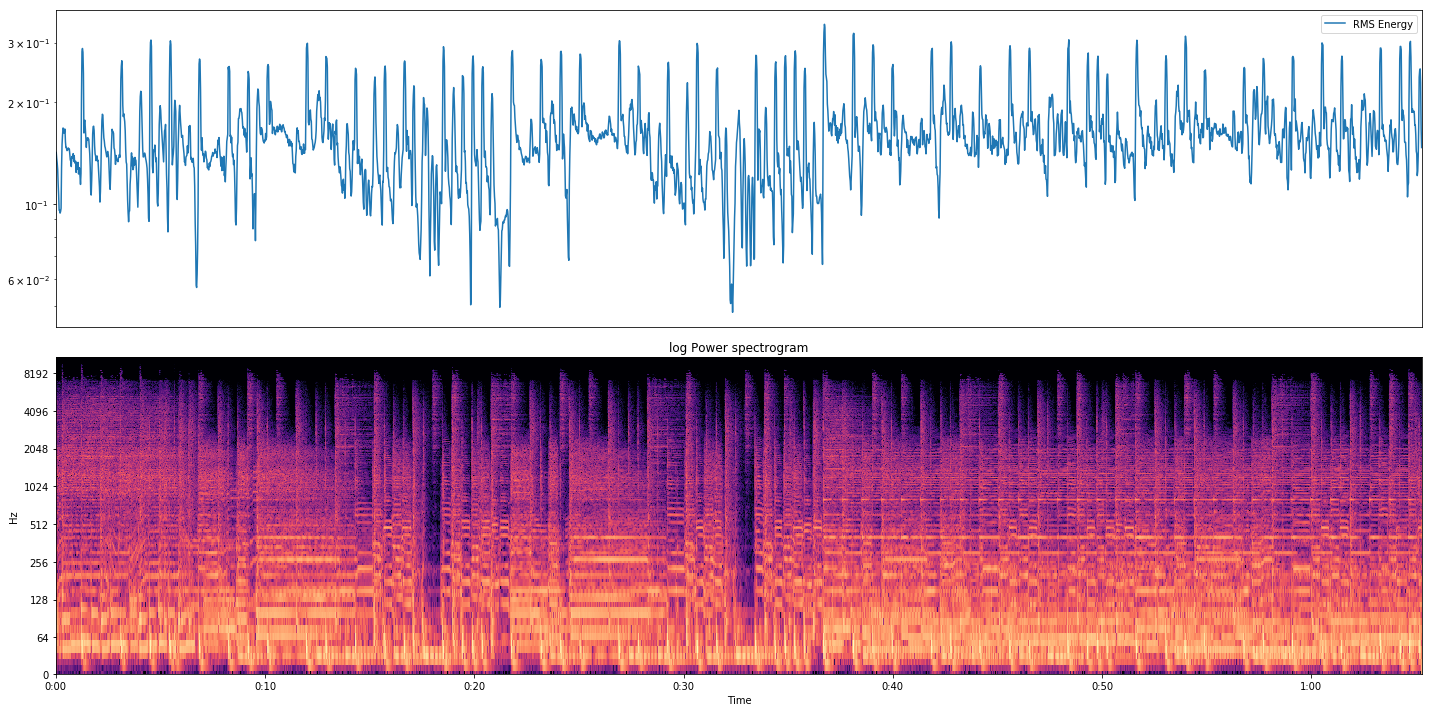

In [110]:
rmse =  librosa.feature.rmse(y=example)


plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.semilogy(rmse.T, label='RMS Energy')
plt.xticks([])
plt.xlim([0, rmse.shape[-1]])
plt.legend(loc='best')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(example_S, ref=np.max),  y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

### spectral_centroid spectral_bandwidth spectral_contrast spectral_rolloff
#### Explanation:
https://en.wikipedia.org/wiki/Roll-off


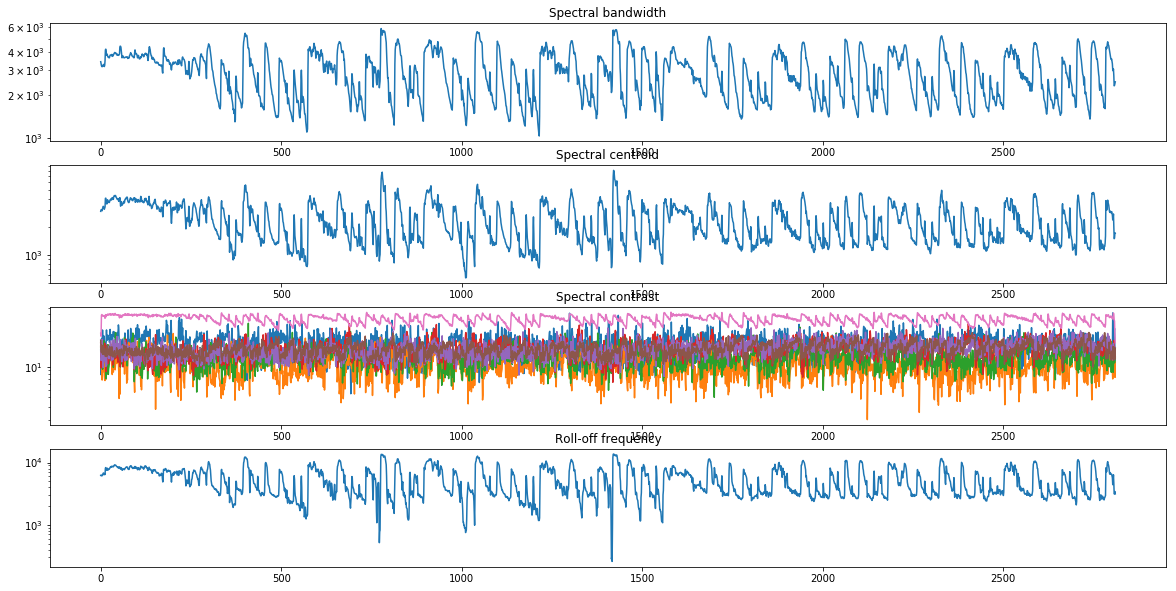

In [122]:
bandwidth = librosa.feature.spectral_bandwidth(y=example, sr=sr)
centroid  = librosa.feature.spectral_centroid(y=example, sr=sr)
contrast  = librosa.feature.spectral_contrast(y=example, sr=sr, n_bands=6)
rolloff   = librosa.feature.spectral_rolloff(y=example, sr=sr)

plt.figure(figsize=(20,10)) 
plt.subplot(4,1,1)
plt.semilogy(bandwidth.T)
plt.title('Spectral bandwidth')
  
plt.subplot(4,1,2)
plt.semilogy(centroid.T)
plt.title('Spectral centroid')

plt.subplot(4,1,3)
plt.semilogy(contrast.T)
plt.title('Spectral contrast')

plt.subplot(4,1,4)
plt.semilogy(rolloff.T)
plt.title('Roll-off frequency')
plt.show()


### Mel Frequency Cepstral Coeﬃcients
#### Explanation:
https://en.wikipedia.org/wiki/Mel_scale
https://es.wikipedia.org/wiki/MFCC

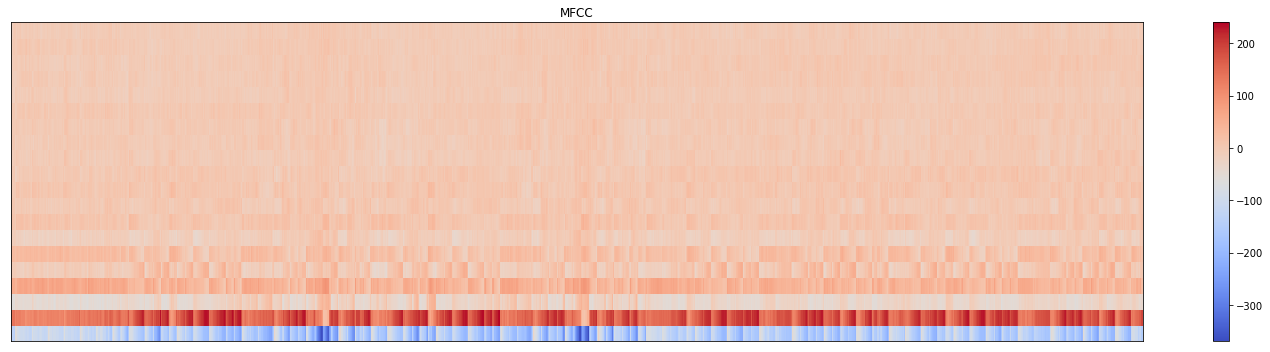

In [127]:
mfcc = librosa.feature.mfcc(y=example, sr=sr,n_mfcc =20)

plt.figure(figsize=(20,5))
librosa.display.specshow(mfcc)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()